# 🧪 Лабораторная работа № 1
## Моделирование элементов радиотехнических устройств (на Python)

**Цель:** Ознакомиться с методами аппроксимации экспериментальных характеристик нелинейных безынерционных элементов и их спектральным анализом.

Вместо MATLAB и CurveExpert используется Python + NumPy/SciPy/Matplotlib.

## 📊 1. Загрузка данных ВАХ диода
Данные представляют собой 2 колонки: напряжение (В) и ток (мА).

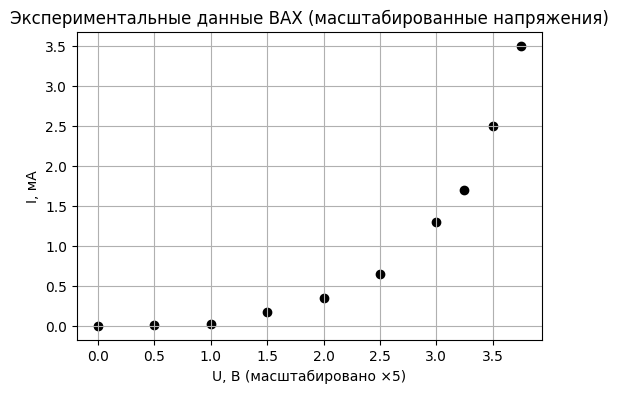

In [28]:
# Загрузка экспериментальных данных и визуализация ВАХ
import numpy as np  # Импортируем NumPy для численных расчётов над массивами
from scipy.optimize import curve_fit  # Нелинейная подгонка для кусочно-линейной и экспоненциальной моделей
import matplotlib.pyplot as plt  # Подключаем инструменты Matplotlib для последующей визуализации

# Загружаем экспериментальные данные из файла
data = np.loadtxt('diode_vah.dat')
U_raw = data[:, 0]
I = data[:, 1]
U = U_raw * 5.0  # Используем масштабированные напряжения согласно заданию

plt.figure(figsize=(6, 4))
plt.scatter(U, I, color='black')
plt.xlabel('U, В (масштабировано ×5)')
plt.ylabel('I, мА')
plt.title('Экспериментальные данные ВАХ (масштабированные напряжения)')
plt.grid()
plt.show()


## 📈 2. Кусочно-линейная аппроксимация

Используем модель с порогом \(U_0\) и крутизной \(S\), описанную в методичке формулой (1.8):\
\(i(U) = S\,(U-U_0)\,H(U-U_0)\), где \(H\) — единичная функция.\
Параметры подбираем по методу наименьших квадратов (1.9): для каждого кандидата порога вычисляем оптимальный наклон и выбираем пару (S, U0) с минимальной квадратичной ошибкой.

S = 2.211 мА/В, U0 = 2.327 В
MSE = 0.050879


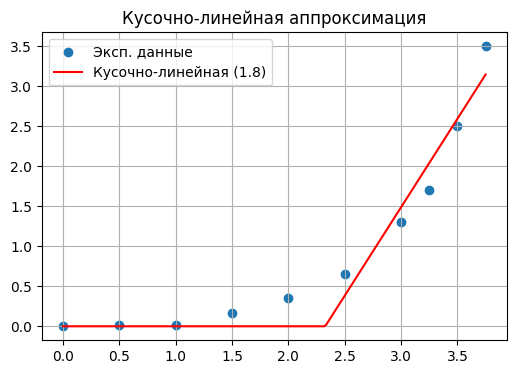

In [29]:
# Реализация кусочно-линейной аппроксимации согласно (1.8)
def kla_model(U, S, U0):
    U = np.asarray(U)
    return np.where(U >= U0, S * (U - U0), 0.0)

def fit_kla_least_squares(U, I, num_grid=1000):
    U = np.asarray(U)
    I = np.asarray(I)
    u_min, u_max = float(U.min()), float(U.max())
    best_S, best_U0, best_err = None, None, np.inf
    for U0 in np.linspace(u_min, u_max, num_grid):
        mask = U >= U0
        if mask.sum() < 2:
            continue  # Нужны хотя бы две точки на активном участке
        denom = np.sum((U[mask] - U0) ** 2)
        if denom < 1e-12:
            continue
        S = np.sum((U[mask] - U0) * I[mask]) / denom
        residuals = I - kla_model(U, S, U0)
        err = np.mean(residuals ** 2)
        if err < best_err:
            best_S, best_U0, best_err = S, U0, err
    if best_S is None:
        raise RuntimeError('Не удалось подобрать параметры кусочно-линейной модели')
    return best_S, best_U0, best_err

S_opt, U0_opt, kla_grid_mse = fit_kla_least_squares(U, I)
popt_kla = (S_opt, U0_opt)
print(f'S = {S_opt:.3f} мА/В, U0 = {U0_opt:.3f} В')
print(f'MSE = {kla_grid_mse:.6f}')

U_dense = np.linspace(U.min(), U.max(), 200)
plt.figure(figsize=(6, 4))
plt.scatter(U, I, label='Эксп. данные')
plt.plot(U_dense, kla_model(U_dense, *popt_kla), 'r-', label='Кусочно-линейная (1.8)')
plt.legend()
plt.grid()
plt.title('Кусочно-линейная аппроксимация')
plt.show()


## 📐 3. Степенная аппроксимация (полиномиальная)

Коэффициенты полинома (от старшего к младшему):
[ 0.06815591 -0.34691626  0.68702127 -0.36707932  0.01456385]


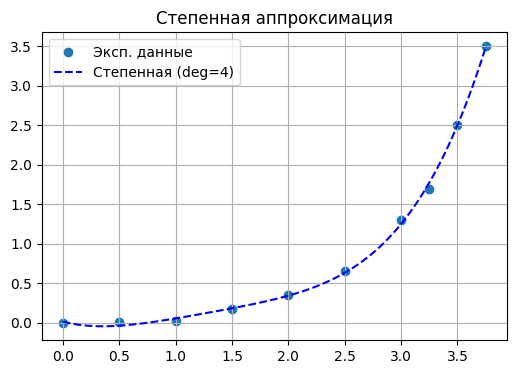

In [30]:
# Полиномиальная аппроксимация экспериментальной кривой\n
degree = 4  # Указываем степень полинома, которым будем аппроксимировать зависимость
coeffs_poly = np.polyfit(U, I, degree)  # Находим коэффициенты полиномиальной аппроксимации по методу наименьших квадратов
I_poly = np.polyval(coeffs_poly, U)  # Вычисляем значения полинома в исходных точках данных
print("Коэффициенты полинома (от старшего к младшему):")  # Сообщаем заголовок перед выводом коэффициентов
print(coeffs_poly)  # Печатаем найденные коэффициенты полинома

plt.figure(figsize=(6,4))
plt.scatter(U, I, label='Эксп. данные')
plt.plot(U_dense, np.polyval(coeffs_poly, U_dense), 'b--', label=f'Степенная (deg={degree})')
plt.legend()
plt.grid()
plt.title('Степенная аппроксимация')
plt.show()

## 🌡 4. Экспоненциальная аппроксимация

I0 = 0.023320 мА, a = 0.7479 В


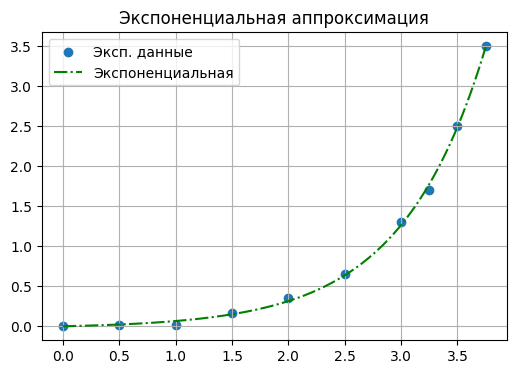

In [31]:
# Экспоненциальная аппроксимация и визуализация результатов

def exp_model(U, I0, a):  # Определяем экспоненциальную модель тока через параметры I0 и a
    return I0 * (np.exp(U / a) - 1)  # Возвращаем предсказанный ток с учётом экспоненциальной зависимости

popt_exp, _ = curve_fit(
    exp_model,
    U,
    I,
    p0=[0.02, 1.0],  # Стартовые приближения учтены для масштабированного диапазона напряжений
    bounds=(0, np.inf),
    maxfev=20000,
)
I0_opt, a_opt = popt_exp  # Извлекаем оценённые значения I0 и a из результата подгонки
print(f"I0 = {I0_opt:.6f} мА, a = {a_opt:.4f} В")  # Выводим параметры экспоненциальной модели в консоль

plt.figure(figsize=(6, 4))
plt.scatter(U, I, label='Эксп. данные')
plt.plot(U_dense, exp_model(U_dense, *popt_exp), 'g-.', label='Экспоненциальная')
plt.legend()
plt.grid()
plt.title('Экспоненциальная аппроксимация')
plt.show()


## ⚡ 5. Генерация гармонического сигнала

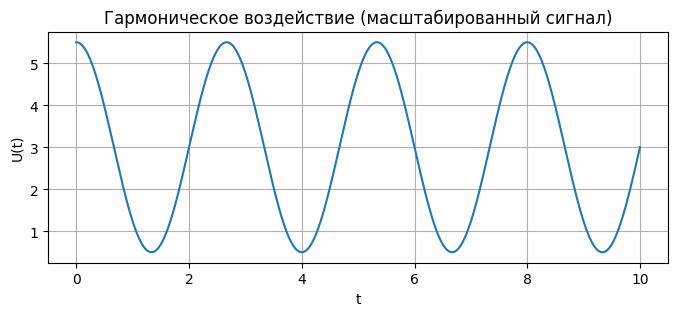

In [32]:
# Формирование гармонического воздействия на входе
Usm = 0.6   # Постоянная составляющая в исходной шкале (В)
Um = 0.5    # Амплитуда гармонической составляющей в исходной шкале (В)
f = 3       # Условная частота гармонического воздействия

scale_factor = 5.0  # Масштаб, использованный для напряжений в исходных данных

t = np.linspace(0, 10, 1000)  # Формируем временной вектор для моделирования
u_in = (Usm + Um * np.cos(f * np.pi / 4 * t)) * scale_factor  # Масштабируем входное напряжение

plt.figure(figsize=(8, 3))
plt.plot(t, u_in)
plt.xlabel('t')
plt.ylabel('U(t)')
plt.title('Гармоническое воздействие (масштабированный сигнал)')
plt.grid()
plt.show()


## 🔌 6. Расчет выходного тока для разных моделей

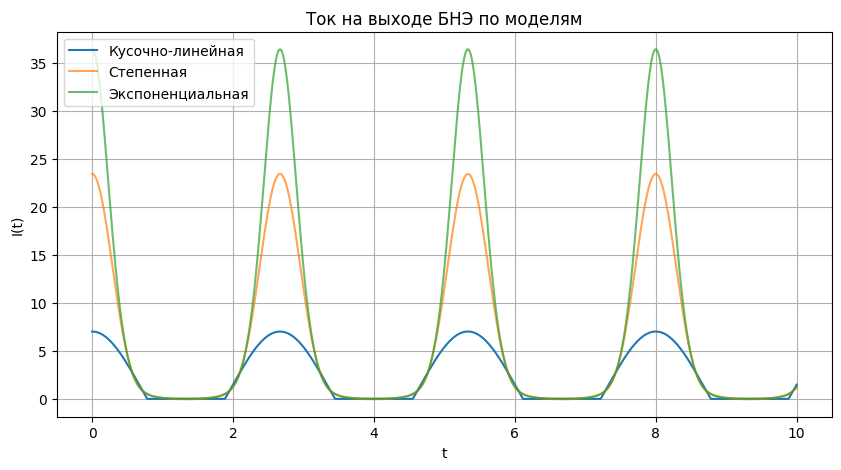

In [33]:
# Сравнение отклика моделей во временной области\n
i_kla = kla_model(u_in, *popt_kla)  # Рассчитываем ток по кусочно-линейной модели на входном сигнале
i_poly = np.polyval(coeffs_poly, u_in)  # Получаем ток по полиномиальной модели для тех же данных
i_exp = exp_model(u_in, *popt_exp)  # Вычисляем ток согласно экспоненциальной модели

plt.figure(figsize=(10,5))
plt.plot(t, i_kla, label='Кусочно-линейная')
plt.plot(t, i_poly, label='Степенная', alpha=0.7)
plt.plot(t, i_exp, label='Экспоненциальная', alpha=0.7)
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('I(t)')
plt.title('Ток на выходе БНЭ по моделям')
plt.show()

## 📉 7. Спектральный анализ (БПФ)

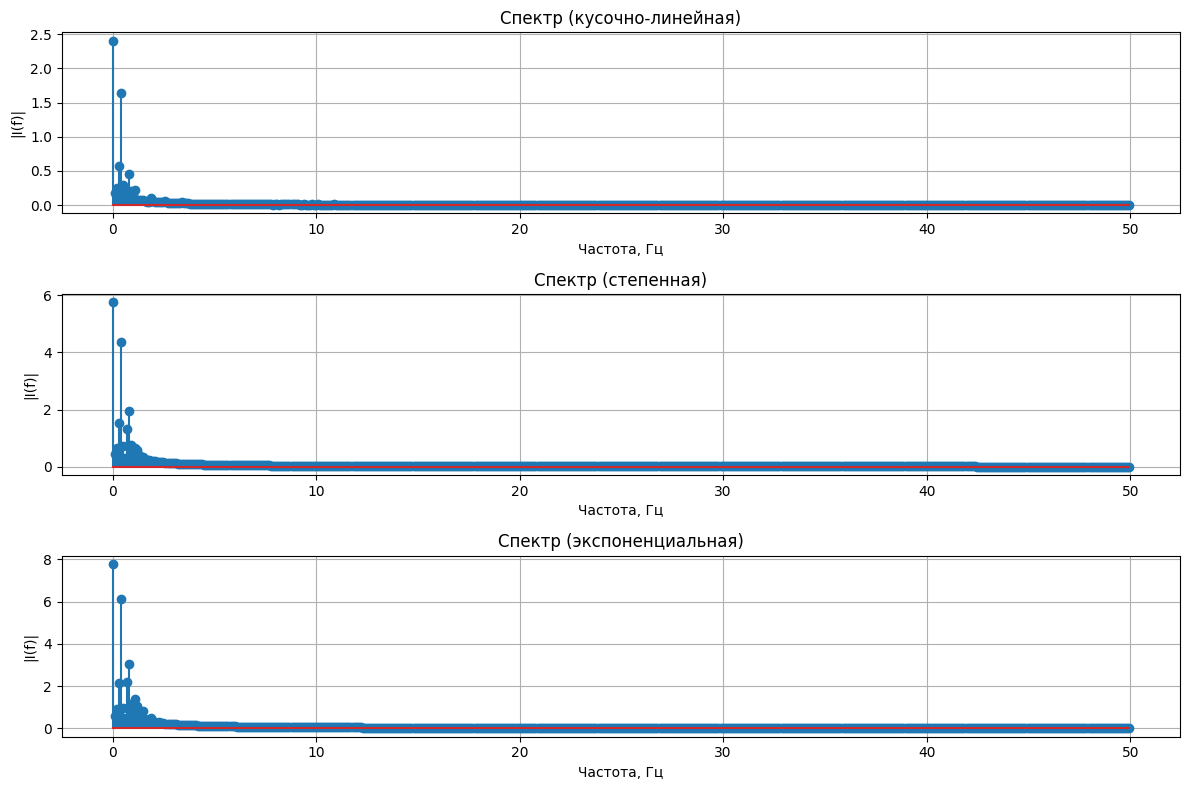

In [34]:
# Анализ спектральных характеристик полученных сигналов\n
def plot_spectrum(signal, title):  # Определяем функцию для расчёта и отображения спектра сигнала
    N = len(signal)  # Определяем количество отсчётов в переданном сигнале
    freq = np.fft.rfftfreq(N, d=(t[1]-t[0]))  # Строим частотную ось для преобразования Фурье
    spectrum = np.abs(np.fft.rfft(signal)) / N  # Вычисляем нормированный модуль спектра сигнала
    plt.stem(freq, spectrum)
    plt.title(title)
    plt.xlabel('Частота, Гц')
    plt.ylabel('|I(f)|')
    plt.grid()

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plot_spectrum(i_kla, 'Спектр (кусочно-линейная)')
plt.subplot(3, 1, 2)
plot_spectrum(i_poly, 'Спектр (степенная)')
plt.subplot(3, 1, 3)
plot_spectrum(i_exp, 'Спектр (экспоненциальная)')
plt.tight_layout()
plt.show()

## 📊 8. Сравнение моделей по ошибке аппроксимации

In [35]:
# Расчёт среднеквадратичных ошибок для сравнения моделей\n
def mse(y_true, y_pred):  # Определяем функцию для расчёта среднеквадратичной ошибки
    return np.mean((y_true - y_pred)**2)  # Возвращаем усреднённую квадратную разность фактических и модельных значений

err_kla = mse(I, kla_model(U, *popt_kla))  # Оцениваем ошибку аппроксимации для кусочно-линейной модели
err_poly = mse(I, np.polyval(coeffs_poly, U))  # Считаем ошибку для полиномиальной модели
err_exp = mse(I, exp_model(U, *popt_exp))  # Вычисляем ошибку для экспоненциальной модели

print("Ошибки аппроксимации (MSE):")  # Сообщаем заголовок перед выводом метрик
print(f"  Кусочно-линейная:   {err_kla:.6f}")  # Выводим ошибку кусочно-линейной модели
print(f"  Степенная:          {err_poly:.6f}")  # Показываем ошибку полиномиальной модели
print(f"  Экспоненциальная:   {err_exp:.6f}")  # Отображаем ошибку экспоненциальной модели


Ошибки аппроксимации (MSE):
  Кусочно-линейная:   0.050879
  Степенная:          0.001228
  Экспоненциальная:   0.001129


## 📋 10. Сравнение параметров моделей

Таблица сводит параметры и качество аппроксимаций, выполненных в Python.

In [42]:
# Формирование таблицы сравнения параметров и ошибок моделей
import pandas as pd

kla_params = f'S={S_opt:.3f}, U0={U0_opt:.3f}'
poly_params = ', '.join([f'a{i}={coef:.3f}' for i, coef in enumerate(coeffs_poly[::-1])])
exp_params = f'I0={I0_opt:.3f}, a={a_opt:.3f}'

comparison_rows = [
    {
        'Модель': 'Кусочно-линейная',
        'MSE (Python)': err_kla,
        'Параметры (Python)': kla_params
    },
    {
        'Модель': 'Степенная (полином)',
        'MSE (Python)': err_poly,
        'Параметры (Python)': poly_params
    },
    {
        'Модель': 'Экспоненциальная',
        'MSE (Python)': err_exp,
        'Параметры (Python)': exp_params
    }
]

comparison_df = pd.DataFrame(comparison_rows)
comparison_df['MSE (Python)'] = comparison_df['MSE (Python)'].map(lambda x: f'{x:.6f}')
display(
    comparison_df.style.set_table_styles([
        {'selector': 'th, td', 'props': [('width', 'auto'), ('white-space', 'normal')]}
    ])
)




,Модель,MSE (Python),Параметры (Python)
0,Кусочно-линейная,0.050879,"S=2.211, U0=2.327"
1,Степенная (полином),0.001228,"a0=0.015, a1=-0.367, a2=0.687, a3=-0.347, a4=0.068"
2,Экспоненциальная,0.001129,"I0=0.023, a=0.748"


## 📝 9. Выводы
- Вставьте сюда свои наблюдения по результатам аппроксимаций и спектрального анализа.
- Укажите, какая модель показала наименьшую ошибку.
- Сделайте сравнение с методами MATLAB / CurveExpert (если применимо).